# User-to-User Similarity Evaluation Script
This script has two parts:
1. Code for model/class creation
2. Evaluation of models across various parameters. The evaluation is done on 3 sets of models. Each set has a different input dataset size (1k, 10k, and 50k playlists). The models within each set have varying k's (nearest neighbors), N (for recall/precision/F1 scores), and cosine calculations (standard, scaled, and soft cosine). Each set of models is evaluated and graphed against the average F1 score with either varying k or varying N. 
3. Final model selection

Required Datasets to be placed in "data" folder
> Note: to help limit total runtime, the pseudo user creation script is set up to output only *pseudo-users-elbow-data* and *psuedo-users-avg-playlists_data*. 
- pseudo-users-elbow-data
- pseudo_users_elbow_data_10000
- pseudo_users_elbow_data_50000
- psuedo-users-avg-playlists_data
- psuedo_users_avg_playlists_data_10000
- psuedo_users_avg_playlists_data_50000

These 6 files are direct outputs of the pseudo user creation script. These 6 files have been provided in the submission package for convenience. 

### Imports

In [24]:
import json # load data
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.feature_extraction import DictVectorizer # convert json data to matrix format
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Section 1: UserSimilarityEvaluator Class

In [25]:
class UserSimilarityEvaluator:
    def __init__(self, json_paths, similarity_method="standard", soft_alpha=1.0):
        valid_methods = {"standard", "scaled", "soft"}
        self.similarity_method = similarity_method.lower()
        if self.similarity_method not in valid_methods:
            raise ValueError(f"Invalid similarity method: '{similarity_method}'. Choose from {valid_methods}")

        self.json_paths = json_paths
        self.similarity_method = similarity_method
        self.soft_alpha = soft_alpha
        self.pseudo_users = []
        self.artist_df = None
        self.similarity_df = None
        self.eval_log = []
    
    ### load the data ### 
    def load_data(self):
        self.pseudo_users = []
        for path in self.json_paths:
            with open(path, "r") as f:
                data = json.load(f)
                self.pseudo_users.extend(data)
    
    ### data test-train split ###
    def split_train_test(self, test_frac=0.2, seed=6740):
        train_users = []
        test_users = []
        for user in self.pseudo_users:
            playlists = user["playlists"]
            if len(playlists) < 2:
                continue  # skip users with too few playlists
            train, test = train_test_split(playlists, test_size=test_frac, random_state=seed)
            train_users.append({"username": user["username"], "playlists": train})
            test_users.append({"username": user["username"], "playlists": test})
        return train_users, test_users

    ### build the user matrix from artist counts ### 
    def build_artist_vectors(self, user_json):
        user_ids = []
        artist_count_dicts = []

        for user in self.pseudo_users:
            user_id = user["username"]
            artist_counter = Counter()

            for playlist in user["playlists"]:
                for track in playlist["tracks"]:
                    artist_uri = track["artist_uri"]
                    artist_counter[artist_uri] += 1

            user_ids.append(user_id)
            artist_count_dicts.append(dict(artist_counter))

        vectorizer = DictVectorizer(sparse=False)
        matrix = vectorizer.fit_transform(artist_count_dicts)
        return pd.DataFrame(matrix, index=user_ids, columns=vectorizer.get_feature_names_out())

    ### compute standard cosine similarity matrix (baseline) ###
    def compute_similarity(self, artist_df):
        if self.similarity_method == 'standard':
            sim_matrix = cosine_similarity(artist_df.values)
            
        ### compute scaled cosine similarity matrix ###
        elif self.similarity_method == 'scaled':
            X = artist_df.values
            sim_matrix = cosine_similarity(X) # get standard cosine matrix
            # calculate norms of vectors from the artist df
            norms = np.linalg.norm(X, axis=1)
            norm_ratios = np.minimum.outer(norms, norms) / np.maximum.outer(norms, norms)
            # multiply standard cosine matrix by norm matrix 
            sim_matrix = sim_matrix * norm_ratios
            np.fill_diagonal(sim_matrix,1.0)
            
        ### compute soft cosine similarity matrix ###
        elif self.similarity_method == 'soft':
            X = artist_df.values
            # numerator: compute dot product
            dot = X @ X.T
            # denominator: compute norms and raise to alpha
            norms = np.linalg.norm(X, axis=1)
            norm_matrix = np.outer(norms, norms) ** self.soft_alpha
            # calculate final soft cosine
            sim_matrix = dot / norm_matrix
            np.fill_diagonal(sim_matrix, 1.0)
            
        else:
            raise ValueError("Invalid similarity method.")
            
        return pd.DataFrame(sim_matrix, index=artist_df.index, columns=artist_df.index)
    
    ### get similarity scores for a given user or pair of users ### 
    def get_user_similarity(self, user1, user2=None, top_x=5):
        """
        Parameters:
            df (pd.DataFrame): similarity df
            user1 (str) : The first user's ID.
            [OPTIONAL] user2 (str): The second user's ID for comparing a pair
            top_x (int): Number of top similar users to return if user2 is not provided
        Returns:
            pd.Series or float
        """
        if user1 not in self.similarity_df.index:
            raise ValueError(f"User {user1} not found")
        if user2:
            if user2 not in self.similarity_df.columns:
                raise ValueError(f"User {user2} not found")
            return self.similarity_df.loc[user1, user2].round(3)
        else:
            top_users = self.similarity_df.loc[user1].drop(user1).sort_values(ascending=False).head(top_x)
            return top_users.round(3)


    ### transform raw cosine score to user interpretable value ### 
    def transform_match_score(self, scores, include_raw=False):
        """
        Converts raw similarity score(s) into interpretable match score(s).

        Parameters:
            scores (float or pd.Series): Output from `get_user_similarity()`
            df (pd.DataFrame): similarity df
            score_type (str): Return 3 transformed (user interpretable) score
                    1) raw cosine score x100
                    2) min-max scaled (0–1) then ×100
                    3) percentile rank value

        Returns:
            float or pd.Series of interpreted match scores
        """
        # triu_indices_from grabs only upper triangle and exclude diagonal
        all_scores = self.similarity_df.values[np.triu_indices_from(self.similarity_df, k=1)]  
        min_score = all_scores.min()
        max_score = all_scores.max()

        def interpret(score, user_label=None):
            # raw score x 100
            raw_score = round(score * 100, 1)
            # min max scaled score x 100
            scaled_score = (score - min_score) / (max_score - min_score)
            scaled_score = round(scaled_score*100,1)
            # percentile rank score (inverted to show top %)
            rank = (all_scores < score).sum()
            percentile_score = round(100*rank / len(all_scores), 1)
            top_percentile_score = round(100 - percentile_score,1)

            base_return = f"{scaled_score}% match, placing you in the top {top_percentile_score}% of user similarities"
            if include_raw:
                base_return += f" (Raw score of {raw_score}%)"
            if user_label:
                return f"- {user_label}: {base_return}"
            return base_return

        if isinstance(scores, pd.Series):
            lines = [interpret(score, user_label=user) for user, score in scores.items()]
            return "\n".join(lines)
        else:
            return interpret(scores)

    ### runs all necessary functions to test output ###
    def run_full_pipeline(self, test_frac=0.2, seed=6740):
        self.load_data()
        train_users, test_users = self.split_train_test(test_frac=test_frac, seed=seed)
        self.train_artist_df = self.build_artist_vectors(train_users)
        self.test_artist_df = self.build_artist_vectors(test_users)
        self.similarity_df = self.compute_similarity(self.train_artist_df)
    
    ### evaluate performance ###
    def evaluate_sim(self, k=5, recall_at=25, print_score=False):
        recalls = []
        precisions = []
        f1s = []

        for user in self.test_artist_df.index:
            # get top-K similar users from train
            top_users = self.similarity_df.loc[user].drop(user).nlargest(k).index
            # aggregate user's artist counts
            combined_vector = self.train_artist_df.loc[top_users].sum(axis=0)
            top_n = min(recall_at, (combined_vector > 0).sum())  # prevent asking for more than exists
            predicted_artists = set(combined_vector.nlargest(top_n).index)
            # user's actual test artists
            actual_artists = set(self.test_artist_df.loc[user][self.test_artist_df.loc[user] > 0].index)
                        
            # compute recall metric
            if len(actual_artists) > 0:
                hits = predicted_artists.intersection(actual_artists)
                recall = len(hits) / len(actual_artists)
                precision = len(hits) / len(predicted_artists)
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                recalls.append(recall)
                precisions.append(precision)
                f1s.append(f1)

        avg_precision = round(np.mean(precisions), 4)
        avg_recall = round(np.mean(recalls), 4)
        avg_f1 = round(np.mean(f1s), 4)
        if print_score:
            print(f"Precision@{recall_at} (k={k}): {avg_precision}")
            print(f"Recall@{recall_at} (k={k}): {avg_recall}")
            print(f"F1@{recall_at} (k={k}): {avg_f1}")
        return {
            "precision": avg_precision,
            "recall": avg_recall,
            "f1": avg_f1
        }

In [32]:
### dynamic function to plot model performance ###
def plot_recall_vs_k_or_n(
    eval_df, fixed="recall_at", fixed_val=50, filter_methods=None, filter_datasets=None, metric_name="Recall"):
    if fixed not in {"recall_at", "k_neighbors"}:
        raise ValueError("fixed must be either 'recall_at' or 'k_neighbors'")
    if metric_name not in {"recall", "precision", "f1"}:
        raise ValueError("metric_name must be 'recall', 'precision', or 'f1'")

    x_axis = "k_neighbors" if fixed == "recall_at" else "recall_at"
    fixed_axis = fixed

    df = eval_df.copy()
    df = df[df[fixed_axis] == fixed_val]
    if filter_methods:
        df = df[df["method"].isin(filter_methods)]
    if filter_datasets:
        df = df[df["dataset"].isin(filter_datasets)]

    df["method_label"] = df["method"] + " (" + df["dataset"].apply(lambda x: "avg" if "avg" in x else "elbow") + ")"
    df["color_group"] = df["method"]  # group methods into same color 
    df["linestyle_label"] = df["dataset"].apply(lambda x: "Average" if "avg" in x else "Elbow")
    df["linestyle"] = df["dataset"].apply(lambda x: "dashed" if "avg" in x else "solid")
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df,
        x=x_axis,
        y=metric_name,
        hue="color_group",
        style="linestyle_label",
        markers=True,
        dashes={"Average": (4,2), "Elbow": ""},
        palette="tab10"
    )
    if fixed == "recall_at":
        plt.title(f"{metric_name.capitalize()}@{fixed_val} vs. Number of Neighbors (k)")
        plt.xlabel("Top K Similar Users")
    else:
        plt.title(f"{metric_name.capitalize()}@N vs. N (k={fixed_val} Similar Users)")
        plt.xlabel("Recall@N")

    plt.ylabel(f"Average {metric_name.capitalize()}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

------

------

# Section 2: Initial Testing and Evaluation Across 3 Input Dataset Sizes

## 2.1: Data Sample 1,000 Playlists

In [27]:
### inits: used for all sample sizes ###
methods = ["standard", "scaled", "soft"]
alphas = [None, None, np.arange(0.1, 1, 0.2)]  # soft cosine only
k_values = [1, 2, 3, 5, 7, 10, 15, 20]
recall_at_values = [1, 3, 5, 10, 25, 50, 100, 200, 500, 1000, 2500]

### define test grid ###
json_configs_1000 = [
    ["data/pseudo-users-elbow-data.json"],
    ["data/psuedo-users-avg-playlists_data.json"]
]


### run for all 6 cases ###
results_1000 = []

for json_paths, dataset_label in zip(json_configs_1000, ["elbow", "avg_playlists"]):
    print(f"\n=== Running for {dataset_label.upper()} data ===")
    for method, alpha_list in zip(methods, alphas):
        print(f"\n   === Running {method.upper()} on {dataset_label}")
        if method == "soft":
            for alpha in alpha_list:
                model_1000 = UserSimilarityEvaluator(json_paths, similarity_method=method, soft_alpha=alpha)
                model_1000.run_full_pipeline()
                for k in k_values:
                    for r in recall_at_values:
                        scores = model_1000.evaluate_sim(k=k, recall_at=r)
                        results_1000.append({
                            "dataset": ", ".join(json_paths),
                            "method": method,
                            "alpha": alpha,
                            "train_users": len(model_1000.train_artist_df),
                            "test_users": len(model_1000.test_artist_df),
                            "k_neighbors": k,
                            "recall_at": r,
                            "precision": scores["precision"],
                            "recall": scores["recall"],
                            "f1": scores["f1"]
                        })
        else:
            model_1000 = UserSimilarityEvaluator(json_paths, similarity_method=method)
            model_1000.run_full_pipeline()
            for k in k_values:
                for r in recall_at_values:
                    scores = model_1000.evaluate_sim(k=k, recall_at=r)
                    results_1000.append({
                        "dataset": ", ".join(json_paths),
                        "method": method,
                        "alpha": None,
                        "train_users": len(model_1000.train_artist_df),
                        "test_users": len(model_1000.test_artist_df),
                        "k_neighbors": k,
                        "recall_at": r,
                        "precision": scores["precision"],
                        "recall": scores["recall"],
                        "f1": scores["f1"]
                    })
                    
                    
### evaluate cases and compare ###
eval_df_1000 = pd.DataFrame(results_1000).drop_duplicates()
eval_df_1000.sort_values(by="f1", ascending=False).head(10)


=== Running for ELBOW data ===

   === Running STANDARD on elbow

   === Running SCALED on elbow

   === Running SOFT on elbow

=== Running for AVG_PLAYLISTS data ===

   === Running STANDARD on avg_playlists

   === Running SCALED on avg_playlists

   === Running SOFT on avg_playlists


,dataset,method,alpha,train_users,test_users,k_neighbors,recall_at,precision,recall,f1
547,data/pseudo-users-elbow-data.json,soft,0.9,19,19,2,500,0.4837,0.3226,0.3522
19,data/pseudo-users-elbow-data.json,standard,NaN,19,19,2,500,0.4837,0.3226,0.3522
107,data/pseudo-users-elbow-data.json,scaled,NaN,19,19,2,500,0.4752,0.3183,0.3473
118,data/pseudo-users-elbow-data.json,scaled,NaN,19,19,3,500,0.4723,0.3148,0.3438
119,data/pseudo-users-elbow-data.json,scaled,NaN,19,19,3,1000,0.3384,0.4305,0.3430
31,data/pseudo-users-elbow-data.json,standard,NaN,19,19,3,1000,0.3386,0.4279,0.3412
20,data/pseudo-users-elbow-data.json,standard,NaN,19,19,2,1000,0.3354,0.4281,0.3399
548,data/pseudo-users-elbow-data.json,soft,0.9,19,19,2,1000,0.3354,0.4281,0.3399
130,data/pseudo-users-elbow-data.json,scaled,NaN,19,19,5,1000,0.3374,0.4235,0.3388
30,data/pseudo-users-elbow-data.json,standard,NaN,19,19,3,500,0.4665,0.3078,0.3367


### *Metric@N vs N*

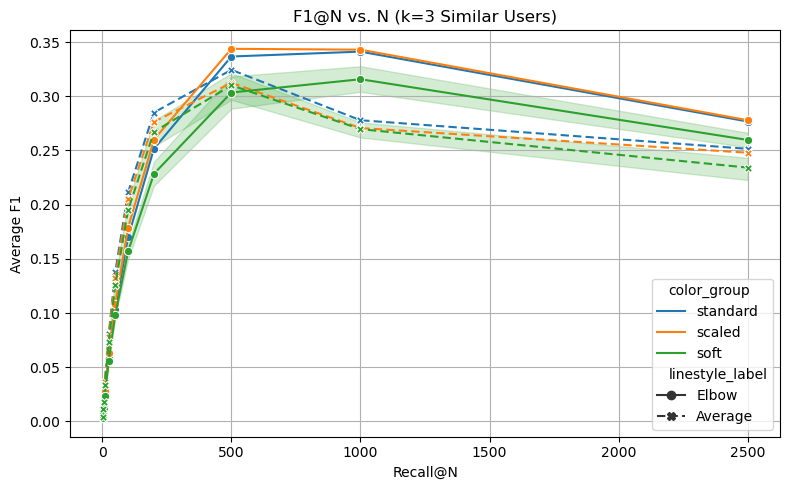

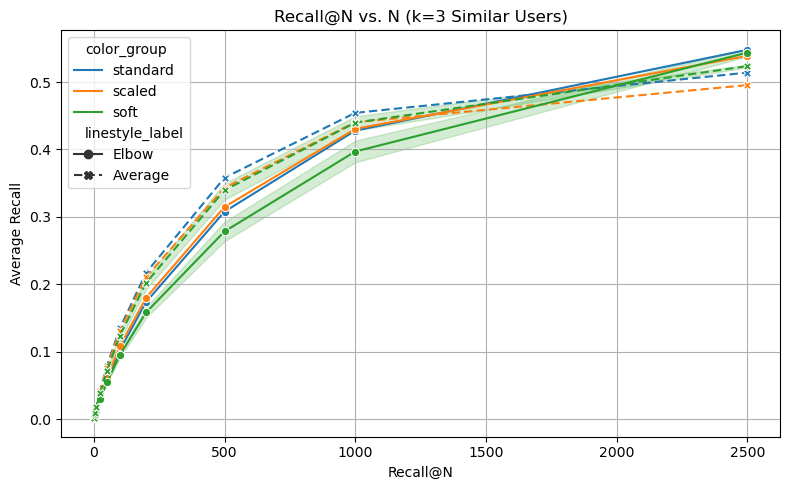

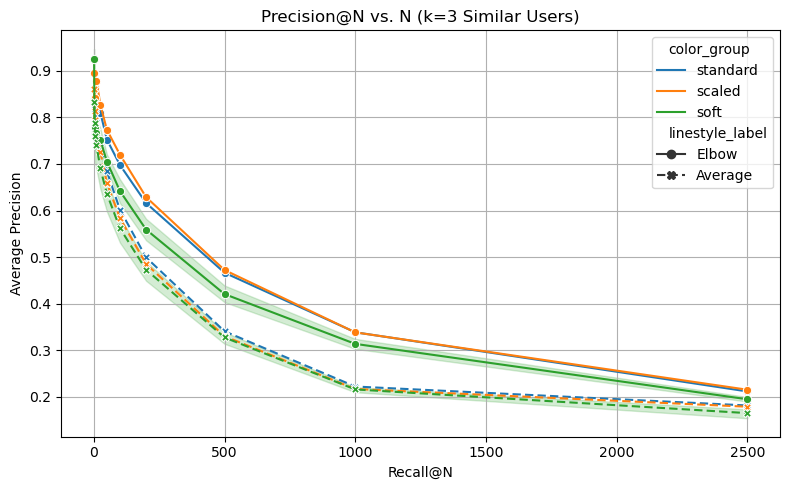

In [45]:
# 1,000 Metric@N vs N
plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="k_neighbors",
    fixed_val=2,
    metric_name="f1"
)

plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="k_neighbors",
    fixed_val=2,
    metric_name="recall"
)

plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="k_neighbors",
    fixed_val=2,
    metric_name="precision"
)

### *Metric@N vs Number of Neighbors (k)*

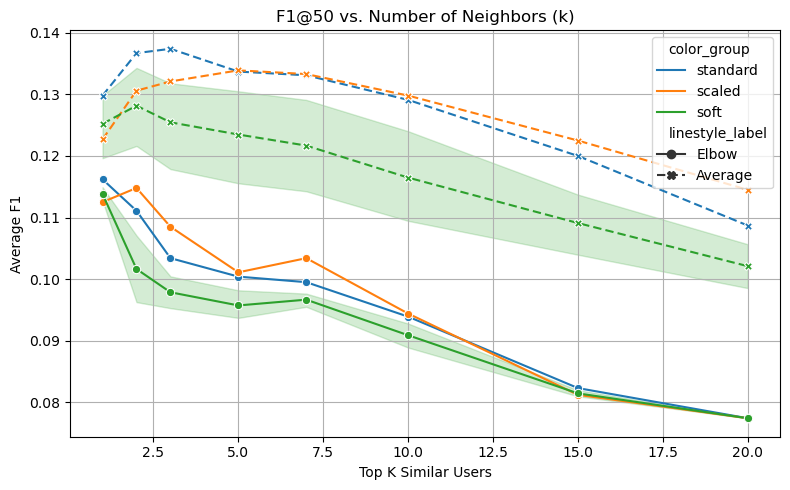

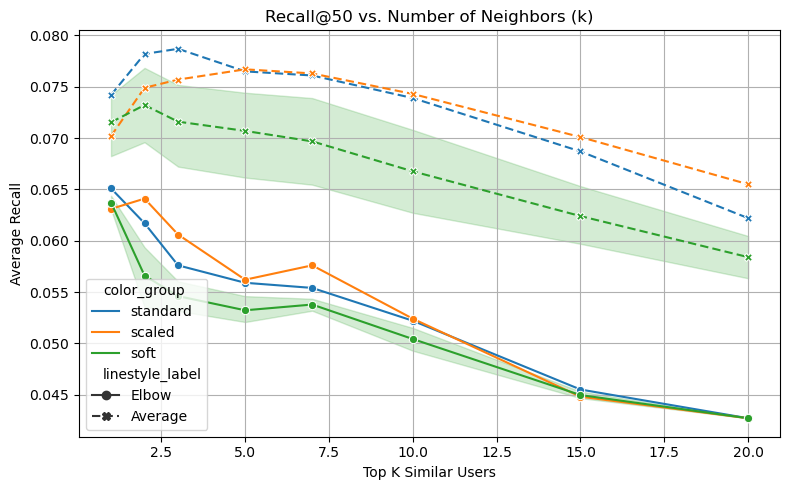

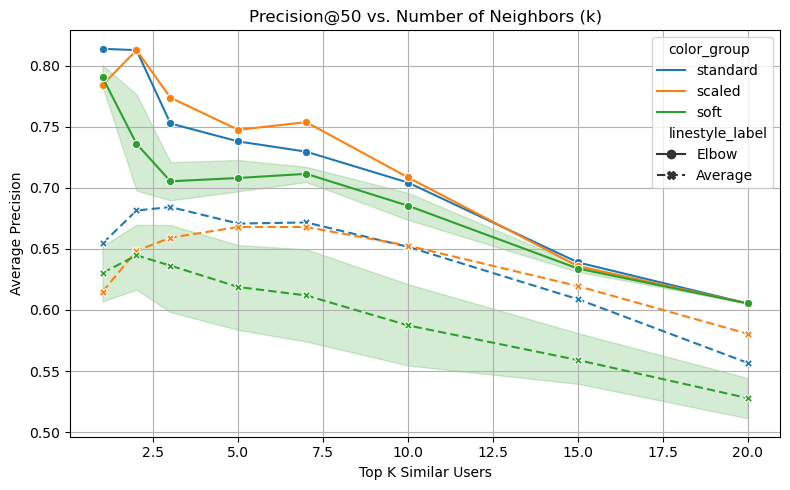

In [46]:
# 1,000 Metric@50 vs k
plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="f1"
)

plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="recall"
)

plot_recall_vs_k_or_n(
    eval_df_1000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="precision"
)

------

## 2.2: Data Sample 10,000 Playlists

In [37]:
### inits: used for all sample sizes ###
methods = ["standard", "scaled"]
k_values = [1, 2, 3, 4, 5, 7, 10]
recall_at_values = [50]

### define test grid ###
json_configs_10000 = [
    ["data/pseudo_users_elbow_data_10000.json"],
    ["data/psuedo_users_avg_playlists_data_10000.json"]
]


### run for all 6 cases ###
results_10000 = []

for json_paths, dataset_label in zip(json_configs_10000, ["elbow", "avg_playlists"]):
    print(f"\n=== Running for {dataset_label.upper()} data ===")
    for method, alpha_list in zip(methods, alphas):
        print(f"\n   === Running {method.upper()} on {dataset_label}")
        model_10000 = UserSimilarityEvaluator(json_paths, similarity_method=method)
        model_10000.run_full_pipeline()
        for k in k_values:
            for r in recall_at_values:
                scores = model_10000.evaluate_sim(k=k, recall_at=r)
                results_10000.append({
                    "dataset": ", ".join(json_paths),
                    "method": method,
                    "alpha": None,
                    "train_users": len(model_10000.train_artist_df),
                    "test_users": len(model_10000.test_artist_df),
                    "k_neighbors": k,
                    "recall_at": r,
                    "precision": scores["precision"],
                    "recall": scores["recall"],
                    "f1": scores["f1"]
                })
                    
                    
### evaluate cases and compare ###
eval_df_10000 = pd.DataFrame(results_10000).drop_duplicates()
eval_df_10000.sort_values(by="f1", ascending=False).head(10)


=== Running for ELBOW data ===

   === Running STANDARD on elbow

   === Running SCALED on elbow

=== Running for AVG_PLAYLISTS data ===

   === Running STANDARD on avg_playlists

   === Running SCALED on avg_playlists


,dataset,method,alpha,train_users,test_users,k_neighbors,recall_at,precision,recall,f1
3,data/pseudo_users_elbow_data_10000.json,standard,None,433,433,4,50,0.7411,0.1065,0.1738
2,data/pseudo_users_elbow_data_10000.json,standard,None,433,433,3,50,0.7375,0.1061,0.1733
4,data/pseudo_users_elbow_data_10000.json,standard,None,433,433,5,50,0.7420,0.1060,0.1732
15,data/psuedo_users_avg_playlists_data_10000.json,standard,None,434,434,4,50,0.7394,0.1062,0.1732
14,data/psuedo_users_avg_playlists_data_10000.json,standard,None,434,434,3,50,0.7353,0.1059,0.1729
16,data/psuedo_users_avg_playlists_data_10000.json,standard,None,434,434,5,50,0.7403,0.1057,0.1727
5,data/pseudo_users_elbow_data_10000.json,standard,None,433,433,10,50,0.7374,0.1049,0.1713
17,data/psuedo_users_avg_playlists_data_10000.json,standard,None,434,434,10,50,0.7360,0.1047,0.1710
11,data/pseudo_users_elbow_data_10000.json,scaled,None,433,433,10,50,0.7345,0.1047,0.1707
1,data/pseudo_users_elbow_data_10000.json,standard,None,433,433,2,50,0.7240,0.1044,0.1705


### *Metric@N vs Number of Neighbors (k)*

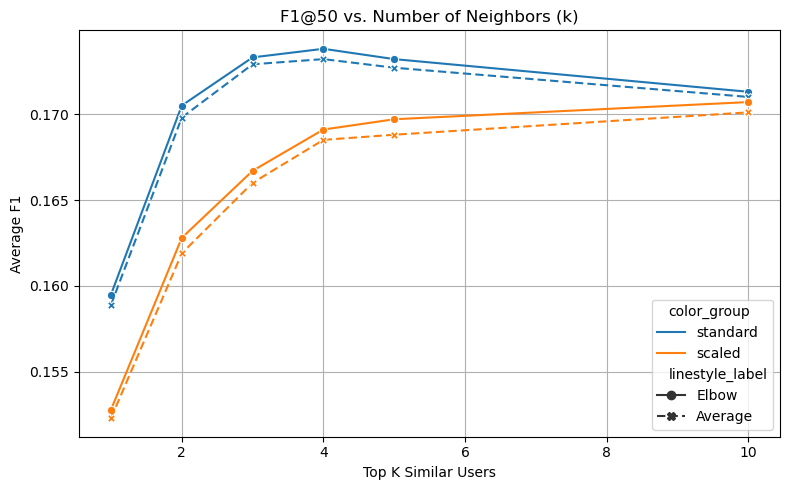

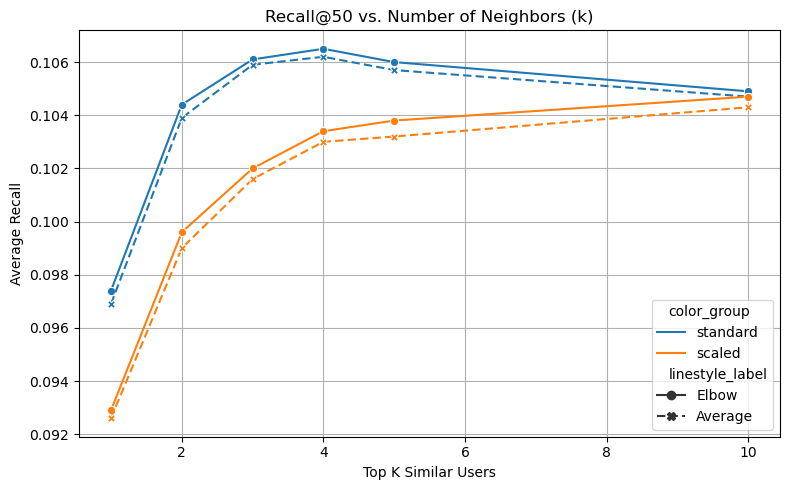

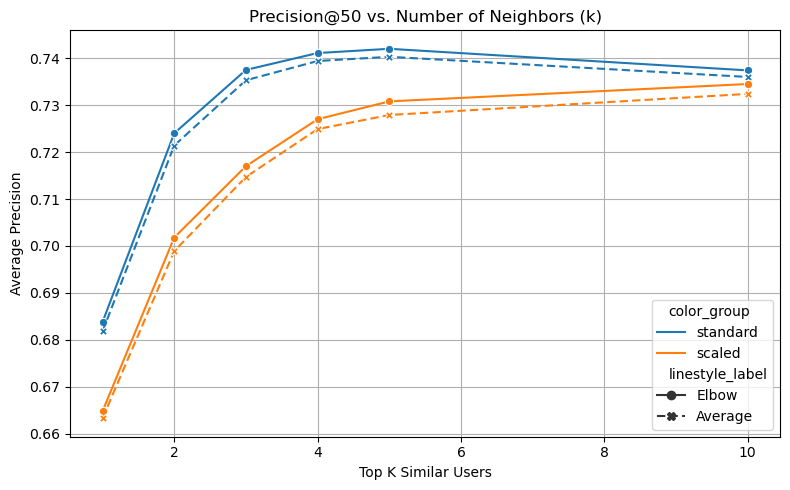

In [47]:
# 10,000 Metric@50 vs k
plot_recall_vs_k_or_n(
    eval_df_10000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="f1"
)

plot_recall_vs_k_or_n(
    eval_df_10000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="recall"
)

plot_recall_vs_k_or_n(
    eval_df_10000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="precision"
)

------

## Data Sample: 50,000 Playlists

In [49]:
### inits: used for all sample sizes ###
methods = ["standard", "scaled"]
k_values = [1, 3, 5, 7, 9, 12, 15]
recall_at_values = [50]

### define test grid ###
json_configs_50000 = [
    ["data/pseudo_users_elbow_data_50000.json"],
    ["data/psuedo_users_avg_playlists_data_50000.json"]
]


### run for all 6 cases ###
results_50000 = []

for json_paths, dataset_label in zip(json_configs_50000, ["elbow", "avg_playlists"]):
    print(f"\n=== Running for {dataset_label.upper()} data ===")
    for method, alpha_list in zip(methods, alphas):
        print(f"\n   === Running {method.upper()} on {dataset_label}")
        model_50000 = UserSimilarityEvaluator(json_paths, similarity_method=method)
        model_50000.run_full_pipeline()
        for k in k_values:
            for r in recall_at_values:
                scores = model_50000.evaluate_sim(k=k, recall_at=r)
                results_50000.append({
                    "dataset": ", ".join(json_paths),
                    "method": method,
                    "alpha": None,
                    "train_users": len(model_50000.train_artist_df),
                    "test_users": len(model_50000.test_artist_df),
                    "k_neighbors": k,
                    "recall_at": r,
                    "precision": scores["precision"],
                    "recall": scores["recall"],
                    "f1": scores["f1"]
                })
                    
                    
### evaluate cases and compare ###
eval_df_50000 = pd.DataFrame(results_50000).drop_duplicates()
eval_df_50000.sort_values(by="f1", ascending=False).head(10)


=== Running for ELBOW data ===

   === Running STANDARD on elbow

   === Running SCALED on elbow

=== Running for AVG_PLAYLISTS data ===

   === Running STANDARD on avg_playlists

   === Running SCALED on avg_playlists


,dataset,method,alpha,train_users,test_users,k_neighbors,recall_at,precision,recall,f1
17,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,7,50,0.7175,0.1277,0.1906
27,data/psuedo_users_avg_playlists_data_50000.json,scaled,None,2173,2173,15,50,0.7169,0.1281,0.1904
26,data/psuedo_users_avg_playlists_data_50000.json,scaled,None,2173,2173,12,50,0.7162,0.1279,0.1902
18,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,9,50,0.7171,0.1274,0.1901
19,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,12,50,0.7163,0.1271,0.1897
25,data/psuedo_users_avg_playlists_data_50000.json,scaled,None,2173,2173,9,50,0.7152,0.1271,0.1896
16,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,5,50,0.7138,0.1270,0.1895
20,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,15,50,0.7138,0.1261,0.1885
24,data/psuedo_users_avg_playlists_data_50000.json,scaled,None,2173,2173,7,50,0.7112,0.1258,0.1880
15,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,3,50,0.7005,0.1234,0.1851


------

### *Metric@N vs N*

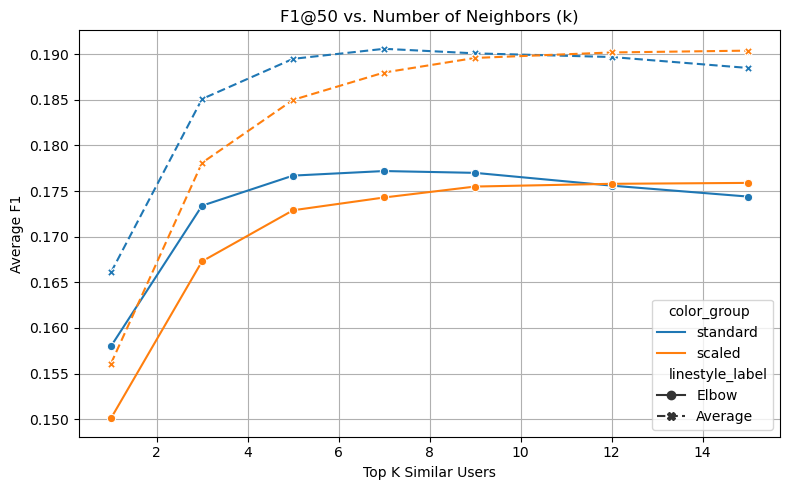

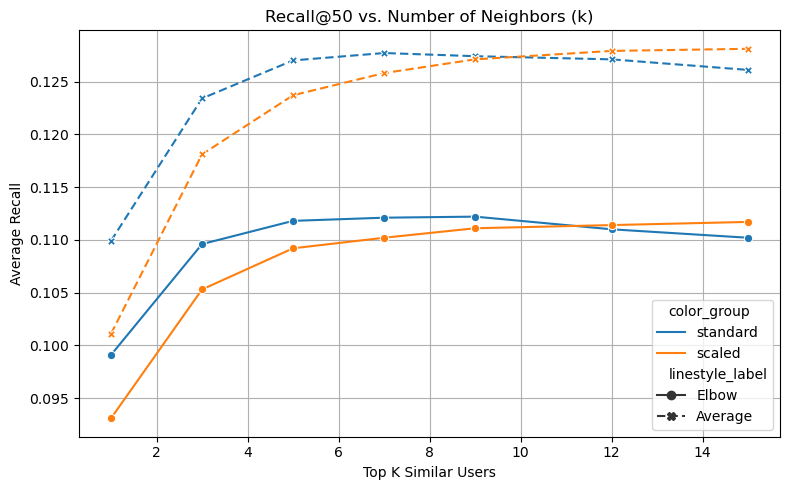

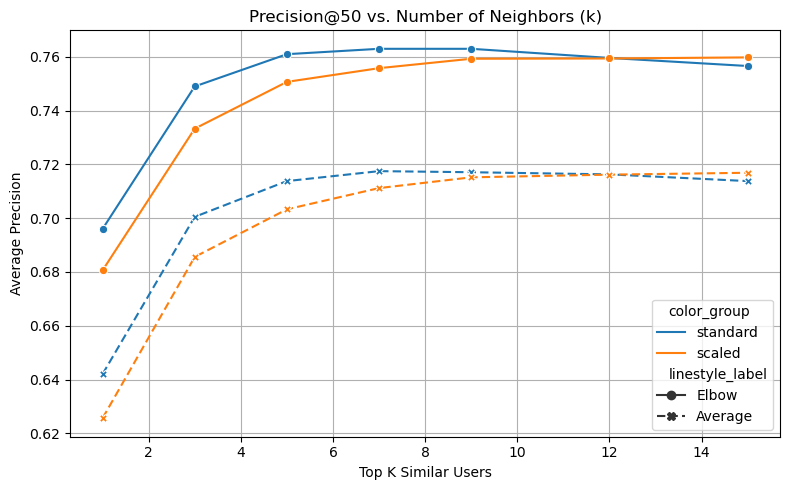

In [50]:
# 50,000 Metric@50 vs k
plot_recall_vs_k_or_n(
    eval_df_50000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="f1"
)

plot_recall_vs_k_or_n(
    eval_df_50000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="recall"
)

plot_recall_vs_k_or_n(
    eval_df_50000,
    fixed="recall_at",
    fixed_val=50,
    metric_name="precision"
)

------

# Section 3: Final Model

In [51]:
### inits: used for all sample sizes ###
methods = ["standard"]
k_values = [7, 8, 9, 15]
recall_at_values = [50]

### define test grid ###
json_configs_final = [
    ["data/pseudo_users_elbow_data_50000.json"],
    ["data/psuedo_users_avg_playlists_data_50000.json"]
]


### run for all 6 cases ###
results_final = []

for json_paths, dataset_label in zip(json_configs_final, ["elbow", "avg_playlists"]):
    print(f"\n=== Running for {dataset_label.upper()} data ===")
    for method, alpha_list in zip(methods, alphas):
        print(f"\n   === Running {method.upper()} on {dataset_label}")
        model_final = UserSimilarityEvaluator(json_paths, similarity_method=method)
        model_final.run_full_pipeline()
        for k in k_values:
            for r in recall_at_values:
                scores = model_final.evaluate_sim(k=k, recall_at=r)
                results_final.append({
                    "dataset": ", ".join(json_paths),
                    "method": method,
                    "alpha": None,
                    "train_users": len(model_final.train_artist_df),
                    "test_users": len(model_final.test_artist_df),
                    "k_neighbors": k,
                    "recall_at": r,
                    "precision": scores["precision"],
                    "recall": scores["recall"],
                    "f1": scores["f1"]
                })
                    
                    
### evaluate cases and compare ###
eval_df_final = pd.DataFrame(results_final).drop_duplicates()
eval_df_final.sort_values(by="f1", ascending=False).head(10)


=== Running for ELBOW data ===

   === Running STANDARD on elbow

=== Running for AVG_PLAYLISTS data ===

   === Running STANDARD on avg_playlists


,dataset,method,alpha,train_users,test_users,k_neighbors,recall_at,precision,recall,f1
4,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,7,50,0.7175,0.1277,0.1906
5,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,8,50,0.7178,0.1279,0.1905
6,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,9,50,0.7171,0.1274,0.1901
7,data/psuedo_users_avg_playlists_data_50000.json,standard,None,2173,2173,15,50,0.7138,0.1261,0.1885
1,data/pseudo_users_elbow_data_50000.json,standard,None,1761,1761,8,50,0.7635,0.1123,0.1773
0,data/pseudo_users_elbow_data_50000.json,standard,None,1761,1761,7,50,0.7630,0.1121,0.1772
2,data/pseudo_users_elbow_data_50000.json,standard,None,1761,1761,9,50,0.7630,0.1122,0.1770
3,data/pseudo_users_elbow_data_50000.json,standard,None,1761,1761,15,50,0.7566,0.1102,0.1744


------